# Denoising from JE Campagne
- Slides JE Denoising slides
https://box.in2p3.fr/index.php/s/5HZsp2YGDzcmPEm


- Installation Sylvie Dagoret-Campagne
- Date : 2024-04-28
- Kernel@ccin2p3 : conda_desc_py310
- Kernel@MacM2 : conda-gpu-py310
- installations:
     - conda install pytorch torchvision -c pytorch
     - conda install conda-forge::appdirs

In [1]:
#!rm -rf './scattering_transform/'
#!git clone 'https://github.com/jecampagne/scattering_transform.git' './scattering_transform/'

In [2]:
import sys
#sys.path.append('/sps/lsst/users/campagne/Textures/scattering_transform/')
#sys.path.append('/sps/lsst/users/campagne/Textures/scattering_transform/')
#sys.path.append('/pbs/throng/lsst/users/dagoret/desc/2024/ImageBackground/scattering_transform')
sys.path.append('/Users/dagoret/gpu-miniconda3/ImagesProcessing/scattering_transform')

In [3]:
import numpy as np
import torch

In [4]:
torch.__version__

'2.4.0.dev20240428'

In [5]:
torch.cuda.is_available()

False

In [6]:
# import scattering package
import scattering

use torch backend


In [7]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Utils

In [8]:
def preprocess(x):
  if x.ndim != 3:
    x = x[np.newaxis]
  x = x.astype(np.float32)
  x = scattering.whiten(x)
  return x

In [9]:
def plot_2img(image1,image2, title_1='',title_2='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    axs[0].set_xticks([]); axs[1].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());
        
def plot_3img(image1,image2, image3, title_1='',title_2='', title_3='', cmap="rainbow",
             colorbar=False, vminmax=None, figsize=(8, 4)):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
    if vminmax is None:
        vmin = image1.mean() - 3*image1.std()
        vmax = image1.mean() + 3*image1.std()
    else:
        vmin,vmax=vminmax
    axs[0].imshow(image1, vmin=vmin, vmax=vmax, cmap=cmap); axs[0].set_title(title_1);
    img = axs[1].imshow(image2, vmin=vmin, vmax=vmax, cmap=cmap); axs[1].set_title(title_2);
    img = axs[2].imshow(image3, vmin=vmin, vmax=vmax, cmap=cmap); axs[2].set_title(title_3);
    axs[0].set_xticks([]); axs[1].set_xticks([]); axs[2].set_xticks([])
    axs[0].set_yticks([]); axs[1].set_yticks([]); axs[2].set_yticks([])
    if colorbar:
        fig.colorbar(img, ax=axs.ravel().tolist());

# Test

In [28]:
!ls

D4.npy                   WLconv_z0.50_0005r.npy   grid.npy
D56.npy                  WLconv_z0.50_0006r.npy   grid3.npy
D62.npy                  WLconv_z0.50_0007r.npy   grid_2.npy
D75.npy                  WLconv_z0.50_0008r.npy   image_denoised.npy
D90.npy                  WLconv_z0.50_0009r.npy   image_orig_noisy.npy
Denoising-original.ipynb WLconv_z0.50_0010r.npy   image_orig_raw.npy
Denoising.ipynb          bubble.npy               image_wn_1.npy
I_1.npy                  bulles.npy               losses.npy
WLconv_z0.50_0001r.npy   cloud.npy                wood.npy
WLconv_z0.50_0002r.npy   cloud3.npy               wood2.npy
WLconv_z0.50_0003r.npy   clouds_tmp.npy
WLconv_z0.50_0004r.npy   face.npy


In [10]:
image_orig_raw = preprocess(np.load("WLconv_z0.50_0001r.npy")[::2,::2])

M,N =  image_orig_raw.shape[1],image_orig_raw.shape[2]
J = int(np.log2(min(M,N))) - 1
L = 4
st_calc = scattering.Scattering2d(M, N, J, L)

sigma_n = 3.
image_wn_1 = np.random.default_rng(seed=1).normal(
                    0.,
                    sigma_n,
                    size=(M,N)
                )
image_wn_1 = image_wn_1[np.newaxis]


image_orig_noisy = image_orig_raw + image_wn_1

In [11]:
M,N

(256, 256)

In [12]:
image_orig_raw.mean(), image_orig_raw.std()

(-1.1175871e-08, 1.0)

In [13]:
image_orig_noisy.mean(), image_orig_noisy.std()

(-0.023698476423773762, 3.1554678047432767)

# Denoise

In [14]:
image_wn_2 = np.random.default_rng(seed=2).normal(
                    0.,
                    sigma_n,
                    size=(M,N)
                )
image_wn_2 = image_wn_2[np.newaxis]


In [15]:
image_wn_n = np.random.default_rng(seed=2).normal(
                    0.,
                    sigma_n,
                    size=(10,M,N)
                )


In [16]:
image_wn_n.shape

(10, 256, 256)

In [17]:
# define loss function
def L2_loss(target, model,factor=1e8):
    return ((target - model)**2).mean()*factor

def test_no_nan(x):
    if type(x) == torch.Tensor or type(x) == torch.nn.parameter.Parameter:
        x = x.detach().cpu().numpy()
    return np.alltrue(~np.isnan(x))

In [18]:
def denoise_gen(
    target, image_init, images_noise,
    mode='image', optim_algorithm='LBFGS', steps=100, learning_rate=0.5,
    device='gpu', precision='single', print_each_step=False, Fourier=False,
    ensemble=False, 
    C11_criteria=None, J=None,L=4, wavelets='morlet',l_oversampling=1, frequency_factor=1,
    normalization='P00',
):
    # define parameters
    N_image = target.shape[0]
    M = target.shape[1]
    N = target.shape[2]
    
    if not torch.cuda.is_available(): device='cpu'
    
    if C11_criteria is None:
        C11_criteria = 'j2>=j1'

    if mode=='image':
        _, M, N = target.shape
        print('input_size: ', target.shape)
        
    if J is None:
        J = int(np.log2(min(M,N))) - 1
    
    #scattering transform 
    st_calc = scattering.ST.Scattering2d(M, N, J, L, device, wavelets, 
                           l_oversampling=l_oversampling, frequency_factor=frequency_factor)
    #index for 2-fields
    select_and_index = st_calc.get_index(J, L, normalization, C11_criteria, num_field = 2)

    
    if mode=='image':
        st_calc.add_ref(ref=target)   # stabilisation cov
        st_calc.add_ref_ab(ref_a=target, ref_b=target)  # stab cov_2fields ?
    
    # formating target and image_init (to tensor, to cuda)
    if type(target)==np.ndarray:
        target = torch.from_numpy(target)
    if type(image_init)==np.ndarray:
        image_init = torch.from_numpy(image_init)
    if type(images_noise)==np.ndarray:
        images_noise = torch.from_numpy(images_noise)
        
    if precision=='double':
        target = target.type(torch.DoubleTensor)
        image_init = image_init.type(torch.DoubleTensor)
        image_noise = image_noise.type(torch.DoubleTensor)
    else:
        target = target.type(torch.FloatTensor)
        image_init = image_init.type(torch.FloatTensor)
        images_noise = images_noise.type(torch.FloatTensor)
    if device=='gpu':
        target      = target.cuda()
        image_init  = image_init.cuda()
    
    # calculate statistics for target images alone
    
    if mode=='image':
        # Phi(d)
        Phi_t = st_calc.scattering_cov(target, use_ref=True,
            C11_criteria=C11_criteria, 
            normalization=normalization,)['for_synthesis']
        
        # S(d,d) non trivial
        coeff_target_target = st_calc.scattering_cov_2fields(target,target, use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
        C01_target_target = coeff_target_target['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
        C01_target_target_r = C01_target_target.real
        C01_target_target_i = C01_target_target.imag
        Corr11_target_target =  coeff_target_target['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
        Corr11_target_target_r = Corr11_target_target.real
        Corr11_target_target_i = Corr11_target_target.imag
        
        #print("C01_target_target shape " ,C01_target_target.shape)
        #print("Corr11_target_target shape ", Corr11_target_target.shape)
        S_t_t = torch.cat((C01_target_target_r,C01_target_target_i,
                          Corr11_target_target_r,Corr11_target_target_i),
                         dim=-1)
        
    else:
        raise ValueError('mode = image only')

    # define optimizable image model
    class OptimizableImage(torch.nn.Module):
        def __init__(self, input_init, Fourier=False):
            # super(OptimizableImage, self).__init__()
            super().__init__()
            self.param = torch.nn.Parameter( input_init )
            
            if Fourier: 
                self.image = torch.fft.ifftn(
                    self.param[0] + 1j*self.param[1],
                    dim=(-2,-1)).real
            else: self.image = self.param
            
            #print("OptimizableImage: init image:",self.image)
            
    if Fourier: 
        temp = torch.fft.fftn(image_init, dim=(-2,-1))
        input_init = torch.cat((temp.real[None,...], temp.imag[None,...]), dim=0)
    else: input_init = image_init
    image_model = OptimizableImage(input_init, Fourier)
    
    
    if optim_algorithm   =='Adam':
        optimizer = torch.optim.Adam(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='NAdam':
        optimizer = torch.optim.NAdam(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='SGD':
        optimizer = torch.optim.SGD(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='Adamax':
        optimizer = torch.optim.Adamax(image_model.parameters(), lr=learning_rate)
    elif optim_algorithm =='LBFGS':
        optimizer = torch.optim.LBFGS(image_model.parameters(), lr=learning_rate, 
            max_iter=steps, max_eval=None, 
            tolerance_grad=1e-19, tolerance_change=1e-19, 
            history_size=min(steps//2, 150), line_search_fn=None)
    
    
    losses_hist = []
    N_noise_img = images_noise.shape[0]
    print("Nber of noise images: ",N_noise_img)

    
    def closure():
        optimizer.zero_grad()
        loss = 0
        
        model_img = image_model.image
        assert test_no_nan(model_img), 'model_img has NaN'        

        
        for i in range(N_noise_img):
            image_noise = images_noise[i]
            if device=='gpu':
                image_noise = image_noise.cuda()

            noisy_model_img = model_img+ image_noise
        
            #Phi(u+n)
            Phi_un = st_calc.scattering_cov(noisy_model_img, use_ref=True,
                C11_criteria=C11_criteria, 
                normalization=normalization,)['for_synthesis']

        
            #S(u+n, u+n)
            coeff_n_model_n_model = st_calc.scattering_cov_2fields(noisy_model_img,noisy_model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
            C01_n_model_n_model   = coeff_n_model_n_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
            C01_n_model_n_model_r = C01_n_model_n_model.real
            C01_n_model_n_model_i = C01_n_model_n_model.imag
            Corr11_n_model_n_model   =  coeff_n_model_n_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
            Corr11_n_model_n_model_r = Corr11_n_model_n_model.real
            Corr11_n_model_n_model_i = Corr11_n_model_n_model.imag
        
            S_un_un = torch.cat((C01_n_model_n_model_r, C01_n_model_n_model_i,
                             Corr11_n_model_n_model_r,Corr11_n_model_n_model_i),
                            dim=-1)
        
            # S(u+n,u)
            coeff_n_model_model =  st_calc.scattering_cov_2fields(noisy_model_img, model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
            Corr00_n_model_model   = coeff_n_model_model['Corr00'].reshape((N_image, -1))
            Corr00_n_model_model_r = Corr00_n_model_model.real
            Corr00_n_model_model_i = Corr00_n_model_model.imag
            C01_n_model_model   = coeff_n_model_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
            C01_n_model_model_r = C01_n_model_model.real
            C01_n_model_model_i = C01_n_model_model.imag
            Corr11_n_model_model   =  coeff_n_model_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
            Corr11_n_model_model_r = Corr11_n_model_model.real
            Corr11_n_model_model_i = Corr11_n_model_model.imag

            S_un_u = torch.cat((Corr00_n_model_model_r,Corr00_n_model_model_i,
                            C01_n_model_model_r,C01_n_model_model_i,
                            Corr11_n_model_model_r,Corr11_n_model_model_i),
                           dim=-1)
            
            if i==0:
                Phi_un_mean = Phi_un
                S_un_un_mean = S_un_un
                S_un_u_mean = S_un_u
            else:
                Phi_un_mean += Phi_un
                S_un_un_mean += S_un_un
                S_un_u_mean += S_un_u

            #free GPU memory
            del image_noise

        # finish the mean computations 
        Phi_un_mean /= N_noise_img
        S_un_un_mean /= N_noise_img
        S_un_u_mean /= N_noise_img

        # S(d,u)
        coeff_target_model =  st_calc.scattering_cov_2fields(target, model_img,use_ref=True,  
                                                             C11_criteria=C11_criteria,
                                                            normalization=normalization,)
        Corr00_target_model   = coeff_target_model['Corr00'].reshape((N_image, -1))
        Corr00_target_model_r = Corr00_target_model.real
        Corr00_target_model_i = Corr00_target_model.imag
        C01_target_model   = coeff_target_model['C01'][:,:,select_and_index['select_2']].reshape((N_image, -1))
        C01_target_model_r = C01_target_model.real
        C01_target_model_i = C01_target_model.imag
        Corr11_target_model   =  coeff_target_model['Corr11'][:,:,select_and_index['select_3']].reshape((N_image,-1))
        Corr11_target_model_r = Corr11_target_model.real
        Corr11_target_model_i = Corr11_target_model.imag

        S_t_u = torch.cat((Corr00_target_model_r,Corr00_target_model_i,
                           C01_target_model_r,C01_target_model_i,
                           Corr11_target_model_r,Corr11_target_model_i),
                          dim=-1)
        
                            
        
        #Gather all peices and build the loss
        factor=1e8
        loss_Phi = L2_loss(Phi_t,Phi_un_mean, factor=factor/1e3)
        loss_S1  = L2_loss(S_t_u,S_un_u_mean, factor=factor)
        loss_S2  = L2_loss(S_t_t,S_un_un_mean,factor=factor)
        loss = loss_Phi + loss_S1 + loss_S2
        
        losses_hist.append([loss_Phi.item() ,loss_S1.item() , loss_S2.item()])
        
        
        if print_each_step:
            if optim_algorithm == 'LBFGS' or (optim_algorithm!='LBFGS' and (i%10==0 or i%10==-1)):
                if not test_no_nan(S_t_t):
                    print("test S_t_t NoK")

                if not test_no_nan(S_t_u):
                    print("test S_t_u NoK")
                    print("Corr00_target_model_r: ", test_no_nan(Corr00_target_model_r))
                    print("Corr00_target_model_i: ", test_no_nan(Corr00_target_model_i))
                    print("C01_target_model_r: ", test_no_nan(C01_target_model_r))
                    print("C01_target_model_i: ", test_no_nan(C01_target_model_i))
                    print("Corr11_target_model_r : ", test_no_nan(Corr11_target_model_r))
                    print("Corr11_target_model_i : ", test_no_nan(Corr11_target_model_i))
                    
                if not test_no_nan(S_un_u):
                    print("test S_un_u NoK")
                if not test_no_nan(S_un_un):
                    print("test S_un_un NoK")
                print("loss_Phi= ",loss_Phi.item(),"loss_S1= ",loss_S1.item(),"loss_S2= ",loss_S2.item())
        loss.backward()
        
        #print("dbg: grad of image_model :",image_model.image.grad)
        
        return loss

    # optimize
    t_start = time.time()
    if optim_algorithm =='LBFGS':
        i=0
        optimizer.step(closure)
    else:
        for i in range(steps):
            #print('step: ', i)
            optimizer.step(closure)
    t_end = time.time()
    print('time used: ', t_end - t_start, 's')

    return image_model.image.cpu().detach().numpy(), losses_hist


In [19]:
image_orig_noisy.shape, image_wn_n.shape

((1, 256, 256), (10, 256, 256))

In [20]:
image_denoised,losses = denoise_gen(image_orig_noisy, image_orig_noisy, image_wn_n, 
                             print_each_step=False, steps=600, learning_rate=0.1, optim_algorithm="LBFGS")

input_size:  (1, 256, 256)
Nber of noise images:  10


/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_69106/1036723338.py:132: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  assert test_no_nan(model_img), 'model_img has NaN'


time used:  10451.002912044525 s


In [21]:
losses = np.array(losses)

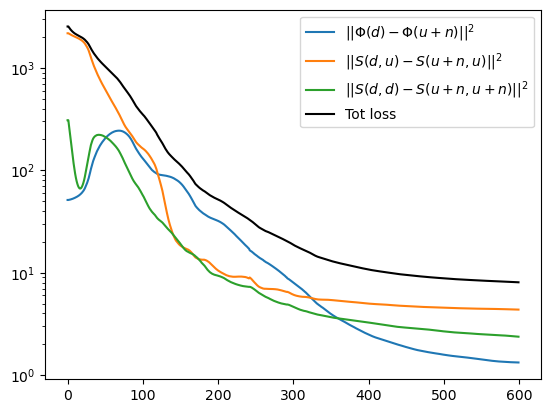

In [22]:
plot(losses[:,0],label="$||\Phi(d)-\Phi(u+n)||^2$")
plot(losses[:,1],label="$||S(d,u)-S(u+n,u)||^2$")
plot(losses[:,2],label="$||S(d,d)-S(u+n,u+n)||^2$")
plot(losses[:,0]+losses[:,1]+losses[:,2],label="Tot loss",c="k")
yscale("log")
legend()

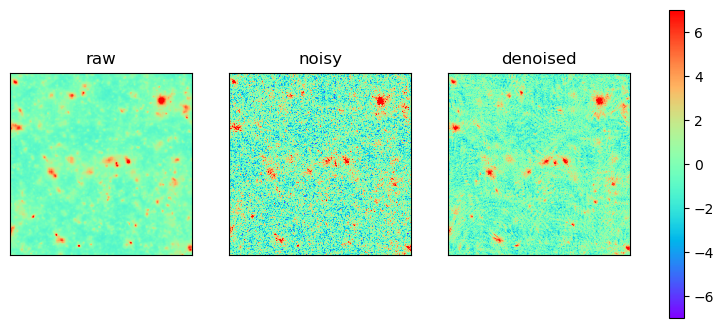

In [23]:
plot_3img(image_orig_raw[0],image_orig_noisy[0], image_denoised[0], colorbar=True, figsize=(10, 4),
         title_1="raw",title_2="noisy",title_3="denoised", vminmax=(-7,7))

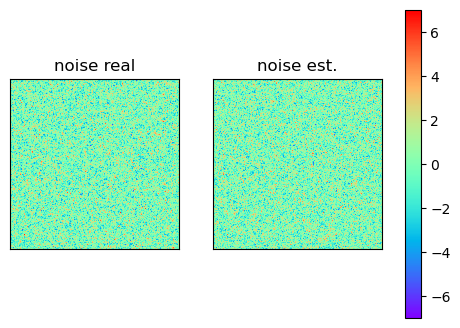

In [24]:
plot_2img(image_wn_1[0],image_orig_noisy[0]-image_denoised[0],colorbar=True, figsize=(6, 4),
         title_1="noise real",title_2="noise est.", vminmax=(-7,7))

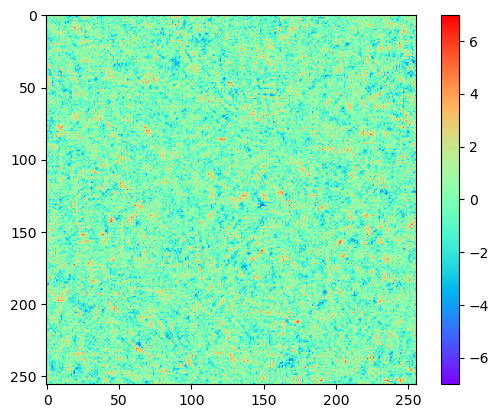

In [25]:
imshow(image_denoised[0]-image_orig_raw[0],vmin=-7,vmax=7, cmap='rainbow');colorbar();

In [26]:
np.save("losses.npy",losses)
np.save("image_orig_raw.npy",image_orig_raw[0])
np.save("image_orig_noisy.npy",image_orig_noisy[0])
np.save("image_denoised.npy",image_denoised[0])

In [27]:
np.save("image_wn_1.npy",image_wn_1[0])